In [1]:
import numpy as np
import json
import os
import gc
from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import TfidfModel
from gensim import corpora,similarities,matutils

from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
%matplotlib inline


c:\users\asus\anaconda3\envs\bio\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

docs = [(doc["id"],(doc["title"]+doc["body"])) for doc in json.load(open(os.path.join("..","similaraty","crag_doc.json"),"r"))]
queries = [(query["query number"],query["query"]) for query in json.load(open(os.path.join("..","similaraty","crag_queries.json"),"r"))][:-1]
relevance = json.load(open(os.path.join("..","similaraty","crag_relevance.json"),"r"))
#try use dictionaries

docs = { k:v for k,v in docs}
queries = { k:v for k,v in queries}

#remove stop words
#docs = { k:remove_stopwords(v) for k,v in docs}
#queries = { k:remove_stopwords(v) for k,v in queries}

print("Num documents",len(docs),"Num queries",len(queries))


Num documents 1400 Num queries 225


In [3]:
#create a queries relevance list
query_relevance = defaultdict(list)

[query_relevance[line["query_num"]].append((line["id"],line["position"])) for line in relevance]

query_relevance = [(k,list(map(lambda t:t[0],sorted(v, key=lambda x:-x[1])))) for k,v in query_relevance.items()]
query_relevance = { k:v for k,v in query_relevance}

In [4]:

#list of words in the data
dataset_words = set()

for q in queries.values():
    dataset_words |= set(word_tokenize(q))
    
for doc in docs.values():
    dataset_words |= set(word_tokenize(doc))
    
dataset_len_vocabulary = len(dataset_words)

In [5]:
PATH_CRAG = "CRAG_OUT_FROM_BIG_FILE_NLTK_TOKENIZER.bin"

model_out = KeyedVectors.load_word2vec_format(PATH_CRAG, binary=True)

print(model_out.vectors.shape)

PATH_CRAG = "CRAG_IN_FROM_BIG_FILE_NLTK_TOKENIZER.bin"

model_in = KeyedVectors.load_word2vec_format(PATH_CRAG, binary=True)

print(model_in.vectors.shape)

(6796, 200)
(6796, 200)


In [11]:
def doc2wordListVec(corpus_dict, ger_embedding):
    
    docs_emb = []

    for i,e in corpus_dict.items():

        doc_emb = []

        for token in word_tokenize(e):
            try:
                doc_emb.append( ger_embedding(token) )
            except KeyError:
                pass #word2vec model doenst have that word

        if len(doc_emb)==0:
            print("miss id ",i)
            continue

        docs_emb.append((i,doc_emb))
        
    return docs_emb


def doc2AVGwordListVec_TFIDF(corpus_dict,corpora_docs,tfidf,get_embedding):
    
    #create tf idf model for the dataset
    docs_tokens = [ word_tokenize(doc) for doc in corpus_dict.values() ]
    
    docs_emb = []

    for i,e in corpus_dict.items():

        doc_emb = {}
        doc_tokens_used = []
        for token in word_tokenize(e):
            try:
                doc_emb[token] = get_embedding(token) 
                doc_tokens_used.append(token)
            except KeyError:
                pass #word2vec model doenst have that word

        if len(doc_emb)==0:
            print("miss id ",i)
            continue

        doc_bow = corpora_docs.doc2bow(doc_tokens_used)
        sentence_tfidf = tfidf[doc_bow]
        sum_tfidf = 0

        for token_id,_tfidf in sentence_tfidf:
            token = corpora_docs[token_id]
            doc_emb[token] = doc_emb[token]*_tfidf
            sum_tfidf += _tfidf

        docs_emb.append((i,sum(doc_emb.values())/sum_tfidf))
        
    return docs_emb

In [12]:
docs_tokens_IN = [ word_tokenize(doc) for doc in docs.values() ]

corpora_docs_IN = corpora.Dictionary(docs_tokens_IN)
tfidf_IN = TfidfModel([corpora_docs_IN.doc2bow(line) for line in docs_tokens_IN])  # fit model

docs_tokens_OUT = [ word_tokenize(doc) for doc in docs.values() ]

corpora_docs_OUT = corpora.Dictionary(docs_tokens_OUT)
tfidf_OUT = TfidfModel([corpora_docs_IN.doc2bow(line) for line in docs_tokens_OUT])  # fit model


#AVG docs embedding with IN embeddings
docs_emb_IN = doc2wordListVec(docs,lambda x : model_in.get_vector(x))
docs_avg_emb_IN = [ (i,sum(doc_emb)/len(doc_emb))  for i,doc_emb in docs_emb_IN ]
docs_avg_embtfidf_IN = doc2AVGwordListVec_TFIDF(docs,corpora_docs_IN,tfidf_IN,lambda x: model_in.get_vector(x))


#test query 1
queries_emb_IN = doc2wordListVec(queries,lambda x : model_in.get_vector(x))
queries_avg_emb_IN = [ (i,sum(q_emb)/len(q_emb))  for i,q_emb in queries_emb_IN ]
queries_avg_embtfidf_IN = doc2AVGwordListVec_TFIDF(queries,corpora_docs_IN,tfidf_IN,lambda x: model_in.get_vector(x))

#AVG docs embedding with OUT embeddings
docs_emb_OUT = doc2wordListVec(docs,lambda x : model_out.get_vector(x)*2)
docs_avg_emb_OUT = [ (i,sum(doc_emb)/len(doc_emb))  for i,doc_emb in docs_emb_OUT ]
docs_avg_embtfidf_OUT = doc2AVGwordListVec_TFIDF(docs,corpora_docs_OUT,tfidf_OUT,lambda x: model_out.get_vector(x)*2)

#test query OUT space
queries_emb_OUT = doc2wordListVec(queries,lambda x : model_out.get_vector(x)*2)
queries_avg_emb_OUT = [ (i,sum(q_emb)/len(q_emb))  for i,q_emb in queries_emb_OUT ]
queries_avg_embtfidf_OUT = doc2AVGwordListVec_TFIDF(queries,corpora_docs_OUT,tfidf_OUT,lambda x: model_out.get_vector(x)*2)


miss id  471
miss id  995
miss id  471
miss id  995
miss id  471
miss id  995
miss id  471
miss id  995


In [13]:
query_id = 1
#relevants document to query 1 IN SPACE

doc_emb_IN_relevants=[ doc_emb for k,doc_emb in docs_avg_emb_IN if str(k) in set(query_relevance[str(query_id)])]
doc_emb_IN_TFIDF_relevants=[ doc_emb for k,doc_emb in docs_avg_embtfidf_IN if str(k) in set(query_relevance[str(query_id)])]

query_emb_IN_relevant = queries_avg_emb_IN[query_id-1][1]
query_embtfidf_IN_relevant = queries_avg_embtfidf_IN[query_id-1][1]

#relevants document to query 1 OUT SPACE

doc_emb_OUT_relevants=[ doc_emb for k,doc_emb in docs_avg_emb_OUT if str(k) in set(query_relevance[str(query_id)])]
doc_emb_OUT_TFIDF_relevants = [ doc_emb for k,doc_emb in docs_avg_embtfidf_OUT if str(k) in set(query_relevance[str(query_id)])]

query_emb_OUT_relevant = queries_avg_emb_OUT[query_id-1][1]
query_embtfidf_OUT_relevant = queries_avg_embtfidf_OUT[query_id-1][1]

In [14]:
pca_IN = PCA(n_components=2)
IN_pca_2d_emb = pca_IN.fit_transform([d for k,d in docs_avg_emb_IN])
print(pca_IN.explained_variance_ratio_)

pca_IN_TFIDF = PCA(n_components=2)
IN_TFIDF_pca_2d_emb = pca_IN_TFIDF.fit_transform([d for k,d in docs_avg_embtfidf_IN])
print(pca_IN_TFIDF.explained_variance_ratio_)

pca_OUT = PCA(n_components=2)
OUT_pca_2d_emb = pca_OUT.fit_transform([d for k,d in docs_avg_emb_OUT])
print(pca_OUT.explained_variance_ratio_)

pca_OUT_TFIDF = PCA(n_components=2)
OUT_TFIDF_pca_2d_emb = pca_OUT_TFIDF.fit_transform([d for k,d in docs_avg_embtfidf_OUT])
print(pca_OUT_TFIDF.explained_variance_ratio_)


[0.15171715 0.09671804]
[0.13867372 0.07106411]
[0.05829984 0.05367087]
[0.04905585 0.03819586]


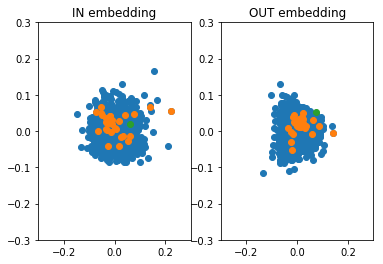

In [15]:
doc_2d_emb_IN_relevants = pca_IN.transform(doc_emb_IN_relevants)
query_2d_emb_IN_relevant = pca_IN.transform([query_emb_IN_relevant])

doc_x_IN, doc_y_IN = zip(*doc_2d_emb_IN_relevants)
query_x_IN, query_y_IN = zip(*query_2d_emb_IN_relevant)
all_x_IN, all_y_IN = zip(*IN_pca_2d_emb)

plt.subplot(1, 2, 1)
plt.scatter(all_x_IN,all_y_IN)
plt.scatter(doc_x_IN,doc_y_IN)
plt.scatter(query_x_IN,query_y_IN)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('IN embedding')

doc_2d_emb_OUT_relevants = pca_OUT.transform(doc_emb_OUT_relevants)
query_2d_emb_OUT_relevant = pca_OUT.transform([query_emb_OUT_relevant])

doc_x_OUT, doc_y_OUT = zip(*doc_2d_emb_OUT_relevants)
query_x_OUT, query_y_OUT = zip(*query_2d_emb_OUT_relevant)
all_x_OUT, all_y_OUT = zip(*OUT_pca_2d_emb)


plt.subplot(1, 2, 2)
plt.scatter(all_x_OUT,all_y_OUT)
plt.scatter(doc_x_OUT,doc_y_OUT)
plt.scatter(query_x_OUT,query_y_OUT)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('OUT embedding')

plt.show()

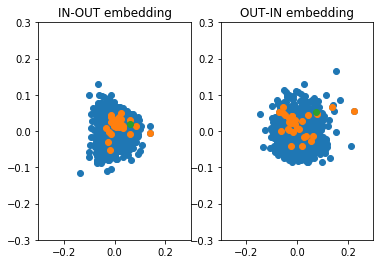

In [16]:
# PROJECT DOCUMENTS OUT SPACE, and query to the IN space

plt.subplot(1, 2, 1)
plt.scatter(all_x_OUT,all_y_OUT)
plt.scatter(doc_x_OUT,doc_y_OUT)
plt.scatter(query_x_IN,query_y_IN)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('IN-OUT embedding')

plt.subplot(1, 2, 2)
plt.scatter(all_x_IN,all_y_IN)
plt.scatter(doc_x_IN,doc_y_IN)
plt.scatter(query_x_OUT,query_y_OUT)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('OUT-IN embedding')

plt.show()

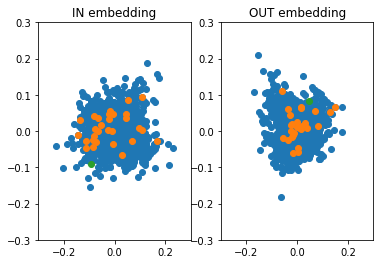

In [17]:
doc_2d_emb_IN_relevants = pca_IN_TFIDF.transform(doc_emb_IN_TFIDF_relevants)
query_2d_emb_IN_relevant = pca_IN_TFIDF.transform([query_embtfidf_IN_relevant])

doc_x_IN, doc_y_IN = zip(*doc_2d_emb_IN_relevants)
query_x_IN, query_y_IN = zip(*query_2d_emb_IN_relevant)
all_x_IN, all_y_IN = zip(*IN_TFIDF_pca_2d_emb)

plt.subplot(1, 2, 1)
plt.scatter(all_x_IN,all_y_IN)
plt.scatter(doc_x_IN,doc_y_IN)
plt.scatter(query_x_IN,query_y_IN)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('IN embedding')

doc_2d_emb_OUT_relevants = pca_OUT_TFIDF.transform(doc_emb_OUT_TFIDF_relevants)
query_2d_emb_OUT_relevant = pca_OUT_TFIDF.transform([query_embtfidf_OUT_relevant])

doc_x_OUT, doc_y_OUT = zip(*doc_2d_emb_OUT_relevants)
query_x_OUT, query_y_OUT = zip(*query_2d_emb_OUT_relevant)
all_x_OUT, all_y_OUT = zip(*OUT_TFIDF_pca_2d_emb)


plt.subplot(1, 2, 2)
plt.scatter(all_x_OUT,all_y_OUT)
plt.scatter(doc_x_OUT,doc_y_OUT)
plt.scatter(query_x_OUT,query_y_OUT)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('OUT embedding')

plt.show()

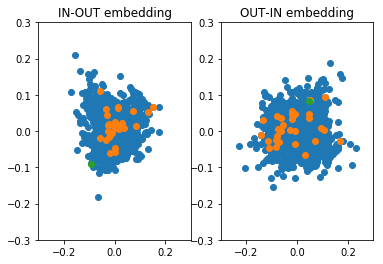

In [18]:
plt.subplot(1, 2, 1)
plt.scatter(all_x_OUT,all_y_OUT)
plt.scatter(doc_x_OUT,doc_y_OUT)
plt.scatter(query_x_IN,query_y_IN)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('IN-OUT embedding')

plt.subplot(1, 2, 2)
plt.scatter(all_x_IN,all_y_IN)
plt.scatter(doc_x_IN,doc_y_IN)
plt.scatter(query_x_OUT,query_y_OUT)
plt.xlim(-0.3, 0.3)
plt.ylim(-0.3, 0.3)
plt.title('OUT-IN embedding')

plt.show()